## Memuat Data

In [1]:
import pandas as pd
from scipy.sparse import coo_matrix  

# Menggunakan path relatif
file_path = "C:/Users\siaha\Documents\Semester 7 version\Sisrek\data-books/train.csv"
data = pd.read_csv(file_path)

# Show the first few rows to understand the structure
data.head()

,user_id,item_id
0,8,0002005018
1,8,074322678X
2,8,0887841740
3,8,1552041778
4,8,1567407781


## Memeriksa Nilai yang Hilang dan Duplikat

In [2]:
# Menghapus baris duplikat
data = data.drop_duplicates()

# Menangani nilai hilang jika ada (misalnya, mengisi dengan nilai 0)
data = data.fillna(0)

## Eksplorasi Interaksi Pengguna dan Item

#### Definisikan Jumlah Interaksi per Pengguna dan per Item

In [3]:
# Menghitung jumlah interaksi untuk setiap pengguna
interaction_count_per_user = data.groupby('user_id').size()

# Menghitung jumlah interaksi untuk setiap item (buku)
interaction_count_per_item = data.groupby('item_id').size()

# Menampilkan ringkasan jumlah interaksi per pengguna dan per item
print("\nJumlah Interaksi per Pengguna (Ringkasan):\n", interaction_count_per_user.describe())
print("\nJumlah Interaksi per Item (Ringkasan):\n", interaction_count_per_item.describe())


Jumlah Interaksi per Pengguna (Ringkasan):
 count    13876.000000
mean        19.441049
std         79.274764
min          4.000000
25%          5.000000
50%          8.000000
75%         16.000000
max       6450.000000
dtype: float64

Jumlah Interaksi per Item (Ringkasan):
 count    123069.000000
mean          2.191974
std           5.389889
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         427.000000
dtype: float64


#### Visualisasi Distribusi Jumlah Interaksi

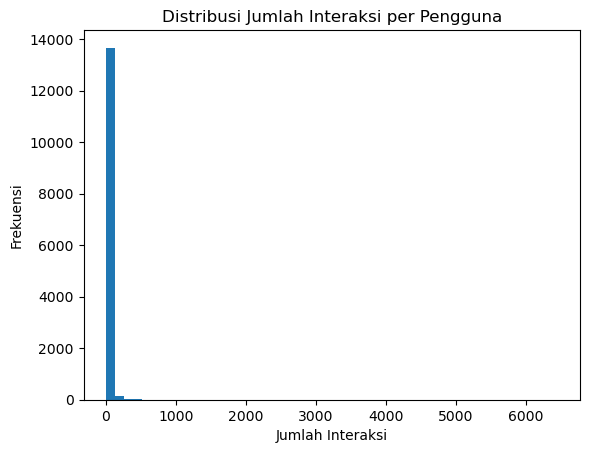

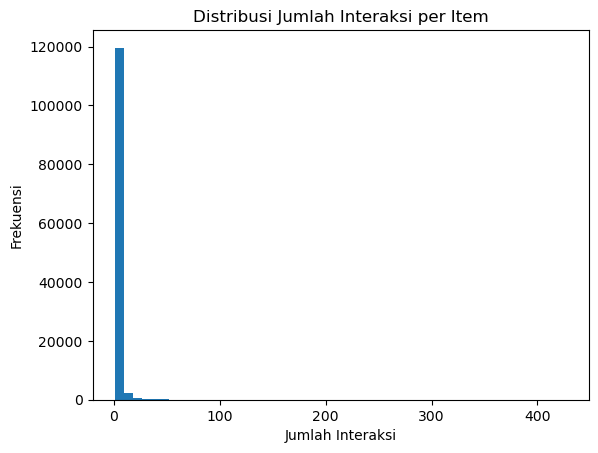

In [4]:
# Impor pustaka untuk visualisasi
import matplotlib.pyplot as plt

# Visualisasi distribusi jumlah interaksi per pengguna
interaction_count_per_user.plot(kind='hist', bins=50, title="Distribusi Jumlah Interaksi per Pengguna")
plt.xlabel("Jumlah Interaksi")
plt.ylabel("Frekuensi")
plt.show()

# Visualisasi distribusi jumlah interaksi per item
interaction_count_per_item.plot(kind='hist', bins=50, title="Distribusi Jumlah Interaksi per Item")
plt.xlabel("Jumlah Interaksi")
plt.ylabel("Frekuensi")
plt.show()

## Menampilkan Top 10 Penggunaa dan Item dengan Interaksi Terbanyak

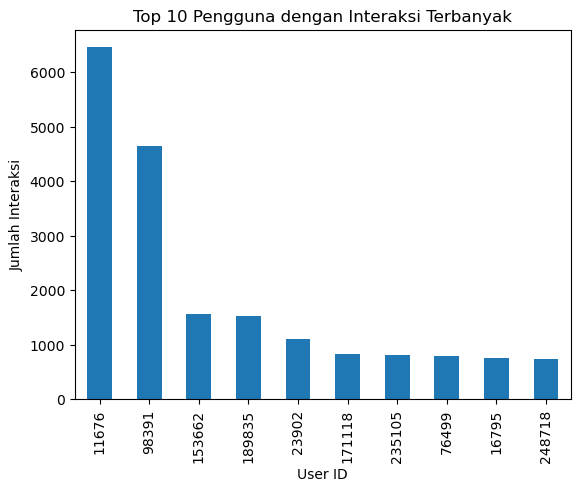

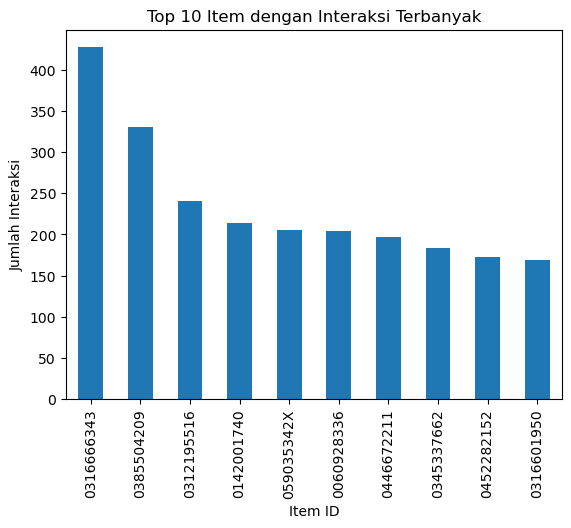

In [5]:
# Menghitung jumlah interaksi untuk setiap pengguna
interaction_count_per_user = data.groupby('user_id').size()

# Menghitung jumlah interaksi untuk setiap item (buku)
interaction_count_per_item = data.groupby('item_id').size()

# Mendapatkan 10 pengguna dengan interaksi terbanyak
top_users = interaction_count_per_user.sort_values(ascending=False).head(10)

# Mendapatkan 10 item dengan interaksi terbanyak
top_items = interaction_count_per_item.sort_values(ascending=False).head(10)

# Visualisasi top 10 pengguna dengan interaksi terbanyak
top_users.plot(kind='bar', title="Top 10 Pengguna dengan Interaksi Terbanyak")
plt.xlabel("User ID")
plt.ylabel("Jumlah Interaksi")
plt.show()

# Visualisasi top 10 item dengan interaksi terbanyak
top_items.plot(kind='bar', title="Top 10 Item dengan Interaksi Terbanyak")
plt.xlabel("Item ID")
plt.ylabel("Jumlah Interaksi")
plt.show()

## Memulai Model ALS

##### Mempersiapkan Data untuk Model ALS

In [6]:
# Menampilkan semua nama kolom untuk memastikan ada kolom 'rating'
print(data.columns)

Index(['user_id', 'item_id'], dtype='object')


In [7]:
# Membuat user-item interaction matrix berdasarkan interaksi yang ada
user_item_matrix = data.pivot(index='user_id', columns='item_id', values='item_id').fillna(0)

# Mengonversi nilai interaksi menjadi 1 untuk setiap interaksi yang ada
user_item_matrix[user_item_matrix != 0] = 1

# Mengonversi matriks ke bentuk sparse
user_item_matrix_sparse = csr_matrix(user_item_matrix.values)

# Melihat bentuk matriks sparse
print(user_item_matrix_sparse.shape)

MemoryError: Unable to allocate 1.59 GiB for an array with shape (13876, 123069) and data type bool

##### Membangun dan Melatih Model ALS

In [ ]:
import implicit

# Membuat model ALS
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)

# Melatih model menggunakan matriks sparse
model.fit(user_item_matrix_sparse)

# Model siap untuk digunakan

##### Membuat Rekomendasi untuk Pengguna

In [ ]:
# Mendapatkan rekomendasi untuk pengguna tertentu (misalnya user_id = 8)
user_id = 8
recommendations = model.recommend(user_id, user_item_matrix_sparse[user_id], N=10, filter_already_liked_items=True)

# Menampilkan rekomendasi yang diberikan oleh model
print(f"Top 10 rekomendasi untuk user {user_id}:")
for item_id, score in recommendations:
    print(f"Item ID: {item_id}, Skor: {score}")

##### Evaluasi Model menggunakan MAP@10

In [ ]:
# Fungsi untuk menghitung MAP@10
def map_at_k(recommended_items, true_items, k=10):
    recommended_items = recommended_items[:k]
    true_items_set = set(true_items)
    return len(set(recommended_items) & true_items_set) / k

# Menghitung MAP@10 untuk setiap pengguna
map_scores = []
for user in data['user_id'].unique():
    true_items = data[data['user_id'] == user]['item_id'].values
    recommended_items = [item[0] for item in model.recommend(user, user_item_matrix_sparse[user], N=10, filter_already_liked_items=True)]
    map_score = map_at_k(recommended_items, true_items, k=10)
    map_scores.append(map_score)

# Menghitung rata-rata MAP@10
mean_map = np.mean(map_scores)
print(f"Rata-rata MAP@10: {mean_map}")

## Langkah Tuning Model ALS

#### Membuat Gird Seacrh

In [ ]:
from sklearn.model_selection import ParameterGrid
import implicit
import numpy as np

# Definisikan grid untuk hyperparameters
param_grid = {
    'factors': [20, 50, 100],         # Jumlah faktor
    'regularization': [0.01, 0.1, 1], # Regularisasi
    'iterations': [10, 20, 30],       # Jumlah iterasi
}

# Fungsi untuk melatih model ALS dan menghitung MAP@10
def train_and_evaluate_als(factors, regularization, iterations):
    # Membuat dan melatih model ALS
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)
    model.fit(user_item_matrix_sparse)
    
    # Menghitung MAP@10 untuk model
    map_scores = []
    for user in data['user_id'].unique():
        true_items = data[data['user_id'] == user]['item_id'].values
        recommended_items = [item[0] for item in model.recommend(user, user_item_matrix_sparse[user], N=10, filter_already_liked_items=True)]
        map_score = map_at_k(recommended_items, true_items, k=10)
        map_scores.append(map_score)

    # Mengembalikan rata-rata MAP@10
    return np.mean(map_scores)

# Melakukan Grid Search
best_map = 0
best_params = None
for params in ParameterGrid(param_grid):
    factors = params['factors']
    regularization = params['regularization']
    iterations = params['iterations']
    
    map_score = train_and_evaluate_als(factors, regularization, iterations)
    if map_score > best_map:
        best_map = map_score
        best_params = params

# Menampilkan hasil terbaik
print(f"Best MAP@10: {best_map}")
print(f"Best Hyperparameters: {best_params}")

##### Evaluasi Model dengan MAP@10

In [ ]:
# Melatih model dengan parameter terbaik
best_model = implicit.als.AlternatingLeastSquares(factors=best_params['factors'], 
                                                 regularization=best_params['regularization'], 
                                                 iterations=best_params['iterations'])
best_model.fit(user_item_matrix_sparse)

# Menghitung MAP@10 pada model terbaik
map_scores = []
for user in data['user_id'].unique():
    true_items = data[data['user_id'] == user]['item_id'].values
    recommended_items = [item[0] for item in best_model.recommend(user, user_item_matrix_sparse[user], N=10, filter_already_liked_items=True)]
    map_score = map_at_k(recommended_items, true_items, k=10)
    map_scores.append(map_score)

# Menghitung rata-rata MAP@10
mean_map = np.mean(map_scores)
print(f"Final MAP@10: {mean_map}")